In [13]:
# Import libraries
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
import skimage.filters
from skimage import io
import json
from pprint import pprint
from tabulate import tabulate
import pandas as pd

In [2]:
# Trigger the authentication flow
ee.Authenticate()

# Initialize the library
ee.Initialize()

Enter verification code: 4/1AY0e-g4luXxIGRUglTV0Uta3C4rqf5-ZWfvOk6J5lLbFTFp2xQLLTxUVTfs

Successfully saved authorization token.


### Exploring sea salinity, temperature, and elevation

https://developers.google.com/earth-engine/datasets/tags/ocean

First experiment with HYCOM

https://developers.google.com/earth-engine/datasets/catalog/HYCOM_sea_temp_salinity#description

In [3]:
# Load geojson file with region of interest
columbia_glacier_file = 'columbia_glacier.geojson'
with open(columbia_glacier_file, 'r') as f:
  fc = json.load(f)

# grab the WGS geometry
geometry = fc['features'][0]['geometry']

# Create region of interest
roi = ee.Geometry(geometry)

pprint(geometry)

{'coordinates': [[[-147.340617, 60.971976],
                  [-147.340617, 61.174791],
                  [-146.728045, 61.174791],
                  [-146.728045, 60.971976],
                  [-147.340617, 60.971976]]],
 'type': 'Polygon'}


In [4]:
js_snippet = """

// Import the time series of global images, filter 15 days in August, 2018.
var dataset = ee.ImageCollection('HYCOM/sea_temp_salinity')
    .filter(ee.Filter.date('2018-08-01', '2018-08-15'));

// Select water temperature at 0 meters and scale to degrees C.
var seaWaterTemperature = dataset.select('water_temp_0')
    .map(function scaleAndOffset(image) {
      return ee.Image(image).multiply(0.001).add(20);
    });

// Define visualization parameters.
var visParams = {
  min: -2.0,  // Degrees C
  max: 34.0,
  palette: ['000000', '005aff', '43c8c8', 'fff700', 'ff0000'],
};

// Display mean 15-day temperature on the map.
Map.setCenter(-88.6, 26.4, 1);
Map.addLayer(seaWaterTemperature.mean(), visParams, 'Sea Water Temperature');

"""

In [5]:
#geemap.js_snippet_to_py(js_snippet, add_new_cell=True, import_ee=False, import_geemap=False, show_map=False)

In [6]:
def scaleAndOffset(image):
    return ee.Image(image).multiply(0.001).add(20)

# Import the time series of global images, filter 15 days in August, 2018.
dataset = ee.ImageCollection('HYCOM/sea_temp_salinity').filter(ee.Filter.date('2018-08-01', '2018-08-15')).select('water_temp_0').map(scaleAndOffset)

# Select water temperature at 0 meters and scale to degrees C.
#seaWaterTemperature = dataset.select('water_temp_0')
seaWaterTemperature = dataset

#seaWaterTemperature= seaWaterTemperature.map(scaleAndOffset)

# Define visualization parameters.
visParams = {
  'min': -2.0,  # Degrees C
  'max': 34.0,
  'palette': ['000000', '005aff', '43c8c8', 'fff700', 'ff0000'],
}

# Columbia Glacier, Alaska coordinates
lat = 61.1202022
lon = -147.1260955

# Display mean 15-day temperature on the map.
Map = geemap.Map()
Map.setCenter(lon, lat, 10)
Map.addLayer(seaWaterTemperature.mean(), visParams, 'Sea Water Temperature')
Map.add_ee_layer(roi)

Map

Map(center=[61.1202022, -147.1260955], controls=(WidgetControl(options=['position'], widget=HBox(children=(Tog…

In [7]:
# Grab the last drawn feature from the map. This will be the new region to study sea surface temperature, salinity, and elevation
#hycom_roi = Map.draw_last_feature.geometry()

# Load geojson file with ocean region of interest to study sea surface temperature, salinity, elevation
ocean_file = 'columbia_glacier.geojson'
with open(ocean_file, 'r') as f:
  fc = json.load(f)

# grab the WGS geometry
ocean_geometry = fc['features'][0]['geometry']

# Create region of interest
hycom_roi = ee.Geometry(ocean_geometry)

pprint(hycom_roi)

'''                
[-147.072193,60.84629],
[-147.072193,60.916681],
[-146.920195,60.916681],
[-146.920195,60.84629],
[-147.072193,60.84629]
'''

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -147.340617,
              60.971976
            ],
            [
              -147.340617,
              61.174791
            ],
            [
              -146.728045,
              61.174791
            ],
            [
              -146.728045,
              60.971976
            ],
            [
              -147.340617,
              60.971976
            ]
          ]
        ]
      }
    }
  }
})


'                \n[-147.072193,60.84629],\n[-147.072193,60.916681],\n[-146.920195,60.916681],\n[-146.920195,60.84629],\n[-147.072193,60.84629]\n'

In [8]:
# Define dates to cycle through
years = [str(2000 + i) for i in range(21)]
start_dates = [str(2000 + i) + '-01-01' for i in range(21)]
end_dates = [str(2000 + i) + '-12-31' for i in range(21)]

In [10]:
# Initialize lists to store the mean temperature and salinity
sea_temp_yrly = dict()
sea_salinity_yrly = dict()

bands = ['water_temp_0', 'salinity_0']

# cycle through the dataset and compute a mean and median
for idx, yr in enumerate(years):
    print("current year: ", yr)
    
    # grab dataset
    dataset = ee.ImageCollection('HYCOM/sea_temp_salinity').filter(ee.Filter.date(start_dates[idx], end_dates[idx])).map(scaleAndOffset)
    
    # compute mean sea water temperature at 0m
    sea_water_temp_mean = dataset.select(bands[0]).mean()
    sea_water_salinity_mean = dataset.select(bands[1]).mean()
    
    mean_temp = sea_water_temp_mean.reduceRegion(reducer=ee.Reducer.mean(),
                                            geometry=hycom_roi,
                                            scale=3500,
                                            bestEffort=True)
    # store mean temp
    sea_temp_yrly[yr] = mean_temp.get(bands[0]).getInfo()
    
    mean_salinity = sea_water_salinity_mean.reduceRegion(reducer=ee.Reducer.mean(),
                                            geometry=hycom_roi,
                                            scale=3500,
                                            bestEffort=True)
    # store mean salinity
    sea_salinity_yrly[yr] = mean_salinity.get(bands[1]).getInfo()
    
    #print("Mean temp: ", mean.getInfo())

current year:  2000
current year:  2001
current year:  2002
current year:  2003
current year:  2004
current year:  2005
current year:  2006
current year:  2007
current year:  2008
current year:  2009
current year:  2010
current year:  2011
current year:  2012
current year:  2013
current year:  2014
current year:  2015
current year:  2016
current year:  2017
current year:  2018
current year:  2019
current year:  2020


In [30]:
# tabulate mean temperature and salinity
mean_temp_df = pd.DataFrame.from_dict(sea_temp_yrly, orient='index', columns=['Mean Temp (C)'])
mean_salinity_df = pd.DataFrame.from_dict(sea_salinity_yrly, orient='index', columns=['Mean Salinity (psu)'])

print("Yearly Mean Sea Temperature at 0m\n")
print(tabulate(mean_temp_df, headers='keys', tablefmt='psql'))
                                                                               
print("\n\nYearly Mean Sea Salinity at 0m\n")
print(tabulate(mean_salinity_df, headers='keys', tablefmt='psql'))

Yearly Mean Sea Temperature at 0m

+------+-----------------+
|      |   Mean Temp (C) |
|------+-----------------|
| 2000 |         7.26037 |
| 2001 |         7.5652  |
| 2002 |         7.20078 |
| 2003 |         8.138   |
| 2004 |         7.439   |
| 2005 |         7.90577 |
| 2006 |         7.21647 |
| 2007 |         6.74186 |
| 2008 |         6.69337 |
| 2009 |         6.97021 |
| 2010 |         7.14969 |
| 2011 |         7.43828 |
| 2012 |         6.51233 |
| 2013 |         9.24374 |
| 2014 |         9.12055 |
| 2015 |         9.53449 |
| 2016 |         9.23391 |
| 2017 |         7.51113 |
| 2018 |         7.93107 |
| 2019 |         7.8546  |
| 2020 |         7.30679 |
+------+-----------------+


Yearly Mean Sea Salinity at 0m

+------+-----------------------+
|      |   Mean Salinity (psu) |
|------+-----------------------|
| 2000 |               29.6144 |
| 2001 |               29.6875 |
| 2002 |               29.4799 |
| 2003 |               29.8743 |
| 2004 |               29

In [37]:
# I stored the data in a dict, but perhaps I should have used a simple list. Dicts are not ordered so simply calling .values()
# may not return the data sorted by years
years_int = [int(year) for year in years]
sea_mean_temp_list = [sea_temp_yrly[yr] for yr in years]
sea_mean_salinity_list = [sea_salinity_yrly[yr] for yr in years]

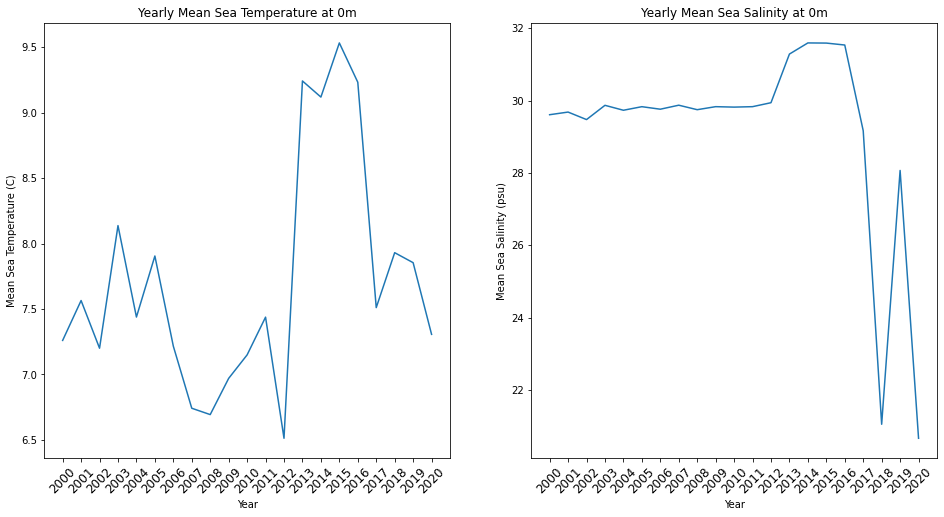

In [39]:
# Plot the mean sea temperature and salinity
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax = ax.ravel()

ax[0].plot(years_int, sea_mean_temp_list)
ax[0].set_xticks([int(year) for year in years])
ax[0].set_xticklabels(years, rotation=45, fontsize=12)
ax[0].set_title('Yearly Mean Sea Temperature at 0m')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Mean Sea Temperature (C)')

ax[1].plot(years_int, sea_mean_salinity_list)
ax[1].set_xticks([int(year) for year in years])
ax[1].set_xticklabels(years, rotation=45, fontsize=12)
ax[1].set_title('Yearly Mean Sea Salinity at 0m')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Mean Sea Salinity (psu)');

### Grabbing sea surface elevation data

In [40]:
mean_sea_lvl_elv = dict()

# cycle through the dataset and compute a mean and median
for idx, yr in enumerate(years):
    print("current year: ", yr)
    
    # grab dataset
    dataset = ee.ImageCollection('HYCOM/sea_surface_elevation').filter(ee.Filter.date(start_dates[idx], end_dates[idx])).select('surface_elevation')
    
    # compute mean sea water temperature at 0m
    sea_surf_elv_mean = dataset.mean()
    
    
    mean_elv = sea_surf_elv_mean.reduceRegion(reducer=ee.Reducer.mean(),
                                            geometry=hycom_roi,
                                            scale=3500,
                                            bestEffort=True)
    # store mean temp
    mean_sea_lvl_elv[yr] = mean_elv.get('surface_elevation').getInfo()


current year:  2000
current year:  2001
current year:  2002
current year:  2003
current year:  2004
current year:  2005
current year:  2006
current year:  2007
current year:  2008
current year:  2009
current year:  2010
current year:  2011
current year:  2012
current year:  2013
current year:  2014
current year:  2015
current year:  2016
current year:  2017
current year:  2018
current year:  2019
current year:  2020


In [41]:
sea_mean_elv_list = [mean_sea_lvl_elv[yr] for yr in years]

Text(0, 0.5, 'Mean Sea Surface Elevation (m)')

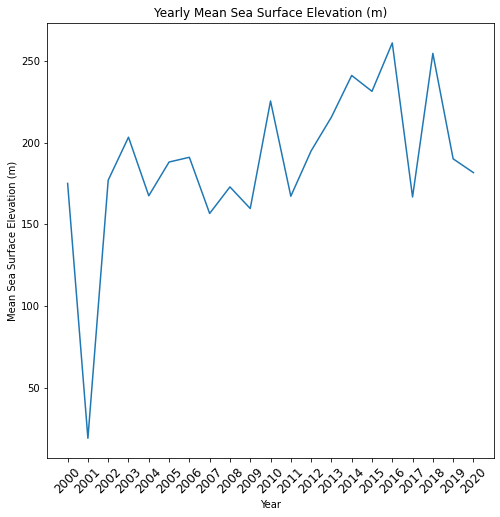

In [42]:
# Plot the mean sea temperature and salinity
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#ax = ax.ravel()

ax.plot(years_int, sea_mean_elv_list)
ax.set_xticks([int(year) for year in years])
ax.set_xticklabels(years, rotation=45, fontsize=12)
ax.set_title('Yearly Mean Sea Surface Elevation (m)')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Sea Surface Elevation (m)')